<a href="https://colab.research.google.com/github/Krish6115/MLLab/blob/main/Lab5/Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Crop_recommendation.csv to Crop_recommendation.csv


==== A1–A2: Linear Regression with ONE feature ====
Feature: [temperature]  ->  Target: rainfall
Train metrics: {'MSE': 3015.235852924874, 'RMSE': 54.9111632814756, 'MAPE_%': 58.427268228317175, 'R2': 0.0009178527615397725}
Test  metrics: {'MSE': 3023.9686688008537, 'RMSE': 54.990623462558176, 'MAPE_%': 54.85834425608317, 'R2': -0.004521591010735682}

==== A3: Linear Regression with MULTIPLE features ====
Features: ['N', 'P', 'K', 'temperature', 'humidity', 'ph']  ->  Target: rainfall
Train metrics: {'MSE': 2898.610446934675, 'RMSE': 53.838744849175995, 'MAPE_%': 58.069570496946376, 'R2': 0.03956105240584573}
Test  metrics: {'MSE': 2973.0491105419815, 'RMSE': 54.52567386600538, 'MAPE_%': 54.93777357968469, 'R2': 0.012393199212950679}

==== A4–A5: KMeans (k=2) + Silhouette/CH/DB ====
Cluster centers (standardized space):
[[-0.67420903  1.40571306  1.45720817 -0.85702691 -0.82715121 -0.31142051
  -0.17695395]
 [ 0.15535465 -0.32391151 -0.33577727  0.19748047  0.19059636  0.07175909
   0.

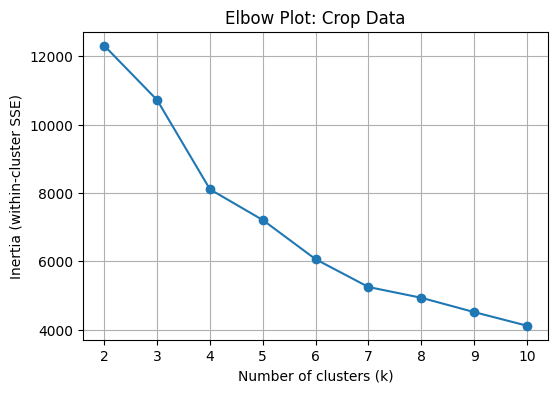

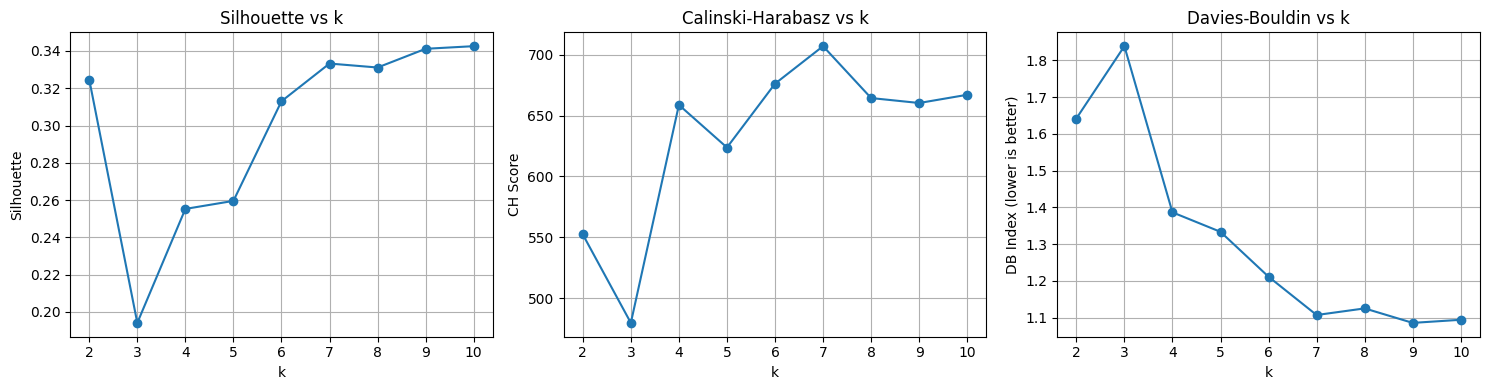

In [5]:
# 23CSE301 — Lab 05
from typing import List, Dict, Tuple
import numpy as np
import pandas as pd

# Modeling / preprocessing / metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans
from sklearn.metrics import (
    silhouette_score, calinski_harabasz_score, davies_bouldin_score
)

# Plotting (used in A7; can be commented out in headless envs)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 4)

# Common utilities
def load_crop_data(path: str) -> pd.DataFrame:
    """
    Load and lightly clean the crop recommendation dataset.
    Assumes columns: N,P,K,temperature,humidity,ph,rainfall,label
    """
    df = pd.read_csv(path)
    df = df.dropna().reset_index(drop=True)  # simple hygiene
    return df


def regression_metrics(y_true: np.ndarray, y_pred: np.ndarray) -> Dict[str, float]:
    """Return MSE, RMSE, MAPE (%), R2 for given true/predicted arrays."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = float(np.sqrt(mse))
    eps = 1e-8  # protects against divide-by-zero in MAPE
    mape = float(np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100.0)
    r2 = r2_score(y_true, y_pred)
    return {"MSE": mse, "RMSE": rmse, "MAPE_%": mape, "R2": r2}

# A1 / A2 / A3 — Linear Regression
# A1. If your project deals with a regression problem, please use one attribute
# (X_train) along with the target values (y_train) for training a Linear Regression model.
# (P.S.: If your project is classification, choose one numeric attribute as the target.)
def a1_train_lr_one_attribute(
    df: pd.DataFrame,
    feature_name: str,
    target_name: str,
    test_size: float = 0.2,
    random_state: int = 42
) -> Tuple[LinearRegression, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Train Linear Regression using a single predictor.
    Returns trained model and the split arrays for A2.
    """
    X = df[[feature_name]].values  # shape (n, 1)
    y = df[target_name].values     # numeric target

    # Train/test split (no scaling required for plain LR here)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    model = LinearRegression().fit(X_train, y_train)  # fit on train only
    return model, X_train, X_test, y_train, y_test

# A2. Calculate MSE, RMSE, MAPE and R2 for predictions made by the trained model in A1.
# Perform prediction on the test data and compare train vs test metrics.
def a2_evaluate_lr(
    model: LinearRegression,
    X_train: np.ndarray, y_train: np.ndarray,
    X_test: np.ndarray,  y_test: np.ndarray
) -> Dict[str, Dict[str, float]]:
    """
    Compute metrics for train and test using an already-trained LR model.
    Returns a dict: {"train": {...}, "test": {...}}
    """
    train_pred = model.predict(X_train)
    test_pred  = model.predict(X_test)
    return {
        "train": regression_metrics(y_train, train_pred),
        "test":  regression_metrics(y_test,  test_pred)
    }

# A3. Repeat A1 & A2 with more than one attribute (or all attributes).
def a3_train_lr_multi_attribute(
    df: pd.DataFrame,
    feature_names: List[str],
    target_name: str,
    test_size: float = 0.2,
    random_state: int = 42,
    scale_features: bool = False
) -> Tuple[LinearRegression, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Train LR using multiple predictors. Optionally standardize features.
    Returns trained model and split arrays for evaluation in A2-style.
    """
    X = df[feature_names].values
    y = df[target_name].values

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )

    # Scaling is optional for LR; keeping false to keep it simple.
    if scale_features:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test  = scaler.transform(X_test)

    model = LinearRegression().fit(X_train, y_train)
    return model, X_train, X_test, y_train, y_test

# A4 / A5 / A6 / A7 — KMeans Clustering
# A4. Perform k-means clustering on your data. Remove/ignore target variable for clustering.
def a4_prepare_features_for_clustering(df: pd.DataFrame) -> np.ndarray:
    """
    Prepare feature matrix for clustering by:
      1) Dropping the categorical 'label' column
      2) Standardizing all numeric features
    Returns standardized feature matrix X_std.
    """
    feature_cols = [c for c in df.columns if c != "label"]
    X = df[feature_cols].values.astype(np.float64)
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    return X_std

# A5. For the clustering done in A4 (e.g., with k=2), calculate:
#     (i) Silhouette Score, (ii) Calinski–Harabasz Score, (iii) Davies–Bouldin Index.
def a5_fit_kmeans_and_scores(
    X_std: np.ndarray, k: int, random_state: int = 42
) -> Tuple[KMeans, Dict[str, float]]:
    """
    Fit KMeans with given k and compute Silhouette, CH, DB metrics.
    Returns fitted model and a dict of metrics (including inertia).
    """
    # n_init="auto" matches the lab handout; if your sklearn is older, use n_init=10.
    km = KMeans(n_clusters=k, random_state=random_state, n_init="auto").fit(X_std)
    labels = km.labels_
    scores = {
        "inertia": km.inertia_,
        "silhouette": silhouette_score(X_std, labels),
        "calinski_harabasz": calinski_harabasz_score(X_std, labels),
        "davies_bouldin": davies_bouldin_score(X_std, labels)
    }
    return km, scores

# A6. Perform k-means for different values of k. Evaluate the above scores for each k.
#     Make a plot of the values vs k to determine optimal cluster count.
def a6_kmeans_grid(
    X_std: np.ndarray, k_values: List[int], random_state: int = 42
) -> pd.DataFrame:
    """
    Run KMeans for each k in k_values and collect inertia + all three metrics.
    Returns a DataFrame with columns: k, inertia, silhouette, calinski_harabasz, davies_bouldin.
    """
    rows = []
    for k in k_values:
        _, s = a5_fit_kmeans_and_scores(X_std, k, random_state=random_state)
        row = {"k": k}
        row.update(s)
        rows.append(row)
    return pd.DataFrame(rows)

# A7. Using elbow plot, determine the optimal k value for k-means clustering.
#     (Plot k vs. inertia (within-cluster SSE).)
def a7_elbow_plot(scores_df: pd.DataFrame, title: str = "Elbow Plot (Inertia vs k)") -> None:
    """
    Plot inertia against k. Look for the 'elbow' where the inertia drop slows down.
    """
    plt.figure()
    plt.plot(scores_df["k"], scores_df["inertia"], marker="o")
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Inertia (within-cluster SSE)")
    plt.title(title)
    plt.grid(True)
    plt.show()


def plot_cluster_quality(scores_df: pd.DataFrame) -> None:
    """
    Helper (optional): visualize the three clustering quality metrics vs k.
    Higher is better for Silhouette/CH, lower is better for DB.
    """
    fig, ax = plt.subplots(1, 3, figsize=(15, 4))
    ax[0].plot(scores_df["k"], scores_df["silhouette"], marker="o")
    ax[0].set_title("Silhouette vs k"); ax[0].set_xlabel("k"); ax[0].set_ylabel("Silhouette"); ax[0].grid(True)

    ax[1].plot(scores_df["k"], scores_df["calinski_harabasz"], marker="o")
    ax[1].set_title("Calinski-Harabasz vs k"); ax[1].set_xlabel("k"); ax[1].set_ylabel("CH Score"); ax[1].grid(True)

    ax[2].plot(scores_df["k"], scores_df["davies_bouldin"], marker="o")
    ax[2].set_title("Davies-Bouldin vs k"); ax[2].set_xlabel("k"); ax[2].set_ylabel("DB Index (lower is better)"); ax[2].grid(True)

    plt.tight_layout()
    plt.show()

# Main
if __name__ == "__main__":

    data_path = "Crop_recommendation.csv"
    df = load_crop_data(data_path)

    # ---------- A1 & A2: LR with one attribute ----------
    # We create a *synthetic regression* task as allowed by the note:
    # Predict the numeric column 'rainfall' using 'temperature' only.
    one_feature = "temperature"
    target_col  = "rainfall"

    model_1, Xtr1, Xte1, ytr1, yte1 = a1_train_lr_one_attribute(df, one_feature, target_col)
    metrics_1 = a2_evaluate_lr(model_1, Xtr1, ytr1, Xte1, yte1)

    print("==== A1–A2: Linear Regression with ONE feature ====")
    print(f"Feature: [{one_feature}]  ->  Target: {target_col}")
    print("Train metrics:", metrics_1["train"])
    print("Test  metrics:",  metrics_1["test"])
    print()

    # ---------- A3: LR with multiple attributes ----------
    # Use all numeric predictors except the target.
    multi_features = ["N", "P", "K", "temperature", "humidity", "ph"]
    model_3, Xtr3, Xte3, ytr3, yte3 = a3_train_lr_multi_attribute(df, multi_features, target_col)
    metrics_3 = a2_evaluate_lr(model_3, Xtr3, ytr3, Xte3, yte3)

    print("==== A3: Linear Regression with MULTIPLE features ====")
    print(f"Features: {multi_features}  ->  Target: {target_col}")
    print("Train metrics:", metrics_3["train"])
    print("Test  metrics:",  metrics_3["test"])
    print()

    # ---------- A4 & A5: KMeans with k=2 + Scores ----------
    X_std = a4_prepare_features_for_clustering(df)  # standardized numeric features (label removed)
    k_example = 2
    km2, scores2 = a5_fit_kmeans_and_scores(X_std, k_example)

    print("==== A4–A5: KMeans (k=2) + Silhouette/CH/DB ====")
    print("Cluster centers (standardized space):")
    print(km2.cluster_centers_)
    print("Scores (k=2):", scores2)
    print()

    # ---------- A6: Metrics for a range of k ----------
    k_values = list(range(2, 11))  # try k = 2..10
    scores_df = a6_kmeans_grid(X_std, k_values)
    print("==== A6: KMeans metrics across k ====")
    print(scores_df.to_string(index=False))
    print("\nNotes: Higher Silhouette & CH are better; lower DB is better.\n")

    # ---------- A7: Elbow Plot ----------
    print("==== A7: Elbow (Inertia vs k) ====")
    a7_elbow_plot(scores_df, title="Elbow Plot: Crop Data")
    # Optional: visualize quality metrics too
    plot_cluster_quality(scores_df)